In [9]:
from rank_bm25 import BM25Okapi
import json
from datasets import load_from_disk
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
with open('../data/wikipedia_documents.json', 'r', encoding='utf-8') as f:
    wiki_data = json.load(f)

documents = [v['text'] for v in wiki_data.values()]

In [3]:
# 토크나이저
def tokenize(text):
    return text.split(' ')

tokenized_corpus = [tokenize(doc) for doc in documents]

In [5]:
train_dataset = load_from_disk('../data/train_dataset')  
train_split = train_dataset['train'] 

queries = [train_split[i]['question'] for i in range(len(train_split))]  
correct_doc_ids = [train_split[i]['document_id'] for i in range(len(train_split))]  

## BM25

In [4]:
bm25 = BM25Okapi(tokenized_corpus)

In [7]:
top_n = 20  
results = []  

for i, query in enumerate(queries):
    tokenized_query = tokenize(query)
    
    doc_scores = bm25.get_scores(tokenized_query)  
    top_n_indices = doc_scores.argsort()[::-1][:top_n]  
    
    correct_doc_id = correct_doc_ids[i]  
    rank = -1
    for rank_idx, doc_index in enumerate(top_n_indices):
        if doc_index == correct_doc_id:
            rank = rank_idx + 1  
            break
    
    results.append({
        'query_id': i,
        'question': query,
        'correct_document_id': correct_doc_id,
        'rank': rank if rank != -1 else "20+"
    })

Query ID 0: Correct document found at rank: 11
Query ID 1: Correct document found at rank: 1
Query ID 2: Correct document found at rank: Not in top 20
Query ID 3: Correct document found at rank: Not in top 20
Query ID 4: Correct document found at rank: 2
Query ID 5: Correct document found at rank: 1
Query ID 6: Correct document found at rank: 1
Query ID 7: Correct document found at rank: 11
Query ID 8: Correct document found at rank: Not in top 20
Query ID 9: Correct document found at rank: Not in top 20
Query ID 10: Correct document found at rank: 3
Query ID 11: Correct document found at rank: 1
Query ID 12: Correct document found at rank: 9
Query ID 13: Correct document found at rank: Not in top 20
Query ID 14: Correct document found at rank: Not in top 20
Query ID 15: Correct document found at rank: 1
Query ID 16: Correct document found at rank: 2
Query ID 17: Correct document found at rank: Not in top 20
Query ID 18: Correct document found at rank: 1
Query ID 19: Correct document f

In [9]:
df_results = pd.DataFrame(results)
df_results.to_csv('bm25_results.csv', index=False)

print("BM25 검색 결과가 'bm25_results.csv'로 저장되었습니다.")

BM25 검색 결과가 'bm25_results.csv'로 저장되었습니다.


## TF-IDF

In [10]:
vectorizer = TfidfVectorizer(tokenizer=tokenize, ngram_range=(1, 2), max_features=50000)
tfidf_matrix = vectorizer.fit_transform(documents)

In [11]:
top_n = 20  
results = [] 

for i, query in enumerate(queries):
    query_vec = vectorizer.transform([query])  
    
    cosine_similarities = (tfidf_matrix * query_vec.T).toarray().squeeze()
    
    top_n_indices = cosine_similarities.argsort()[::-1][:top_n]

    correct_doc_id = correct_doc_ids[i] 
    rank = -1
    for rank_idx, doc_index in enumerate(top_n_indices):
        if doc_index == correct_doc_id:  
            rank = rank_idx + 1 
            break
    
    results.append({
        'query_id': i,
        'question': query,
        'correct_document_id': correct_doc_id,
        'rank': rank if rank != -1 else "20+"
    })

df_results = pd.DataFrame(results)
df_results.to_csv('tfidf_results.csv', index=False)

print("TF-IDF 검색 결과가 'tfidf_results.csv'로 저장되었습니다.")

TF-IDF 검색 결과가 'tfidf_results.csv'로 저장되었습니다.


## 결과 분석

In [12]:
import matplotlib.pyplot as plt

file_path = 'retrieve_result.csv'
df = pd.read_csv(file_path)

In [13]:
# 20+은 실패로 간주, 성공은 rank 1~20
df['bm25_success'] = df['bm25'].apply(lambda x: 'Success' if x != '20+' else 'Fail')
df['tfidf_success'] = df['tf-idf'].apply(lambda x: 'Success' if x != '20+' else 'Fail')

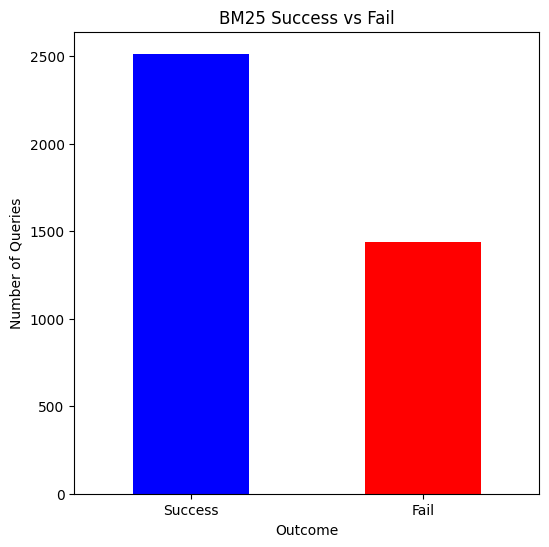

In [30]:
bm25_success_counts = df['bm25_success'].value_counts()

plt.figure(figsize=(6, 6))
bm25_success_counts[['Success', 'Fail']].plot(kind='bar', color=['blue', 'red'], rot=0)
plt.title('BM25 Success vs Fail')
plt.xlabel('Outcome')
plt.ylabel('Number of Queries')

plt.show()

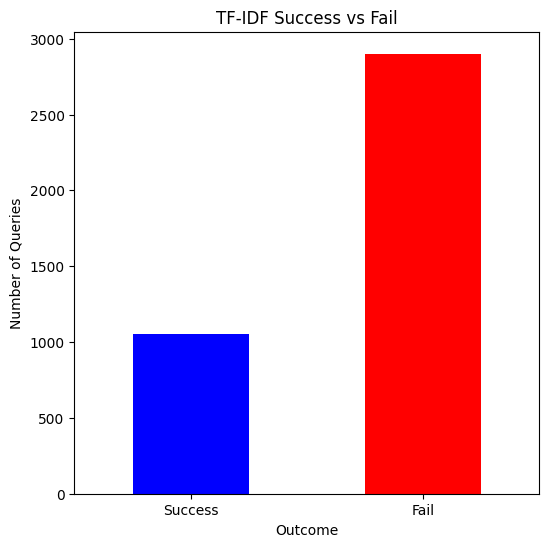

In [31]:
tfidf_success_counts = df['tfidf_success'].value_counts()

plt.figure(figsize=(6, 6))
tfidf_success_counts[['Success', 'Fail']].plot(kind='bar', color=['blue', 'red'], rot=0)
plt.title('TF-IDF Success vs Fail')
plt.xlabel('Outcome')
plt.ylabel('Number of Queries')

plt.show()

/tmp/ipykernel_821567/44915867.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bm25_valid['bm25'] = df_bm25_valid['bm25'].astype(int)


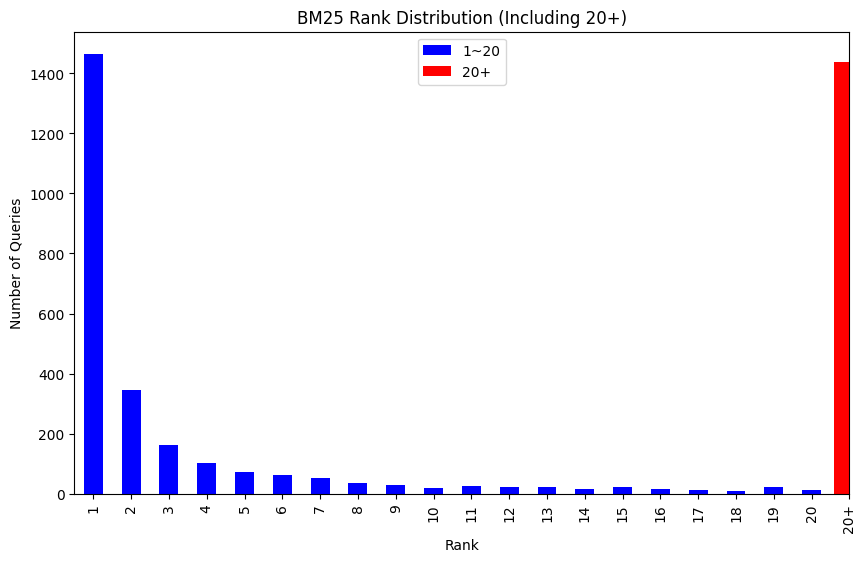

In [33]:
df_bm25_valid = df[df['bm25'] != '20+']
df_bm25_valid['bm25'] = df_bm25_valid['bm25'].astype(int)

bm25_20_plus_count = (df['bm25'] == '20+').sum()

plt.figure(figsize=(10, 6))

rank_counts = df_bm25_valid['bm25'].value_counts().sort_index()
rank_counts.plot(kind='bar', color='blue', label='1~20')
plt.bar(x=[20], height=[bm25_20_plus_count], color='red', label='20+')

plt.title('BM25 Rank Distribution (Including 20+)')
plt.xlabel('Rank')
plt.ylabel('Number of Queries')
plt.xticks(range(21), list(range(1, 21)) + ['20+'])  # 1~20 + 20+
plt.legend()
plt.show()

/tmp/ipykernel_821567/2136238682.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tfidf_valid['tf-idf'] = df_tfidf_valid['tf-idf'].astype(int)


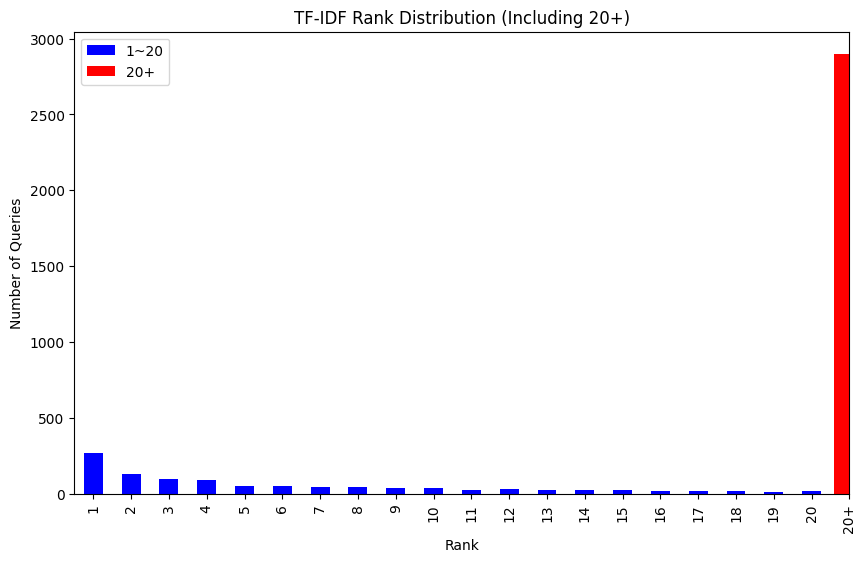

In [34]:
df_tfidf_valid = df[df['tf-idf'] != '20+']
df_tfidf_valid['tf-idf'] = df_tfidf_valid['tf-idf'].astype(int)

tfidf_20_plus_count = (df['tf-idf'] == '20+').sum()

plt.figure(figsize=(10, 6))

rank_counts = df_tfidf_valid['tf-idf'].value_counts().sort_index()
rank_counts.plot(kind='bar', color='blue', label='1~20')
plt.bar(x=[20], height=[tfidf_20_plus_count], color='red', label='20+')

plt.title('TF-IDF Rank Distribution (Including 20+)')
plt.xlabel('Rank')
plt.ylabel('Number of Queries')
plt.xticks(range(21), list(range(1, 21)) + ['20+'])  # 1~20 + 20+
plt.legend()
plt.show()

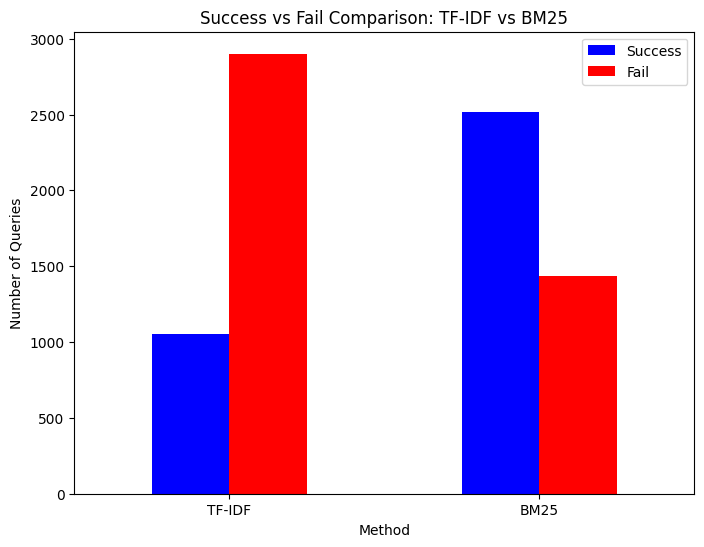

In [35]:
bm25_counts = df['bm25_success'].value_counts()
tfidf_counts = df['tfidf_success'].value_counts()

df_combined = pd.DataFrame({
    'TF-IDF': tfidf_counts,
    'BM25': bm25_counts
})

df_combined.T[['Success', 'Fail']].plot(kind='bar', color=['blue', 'red'], figsize=(8, 6), rot=0)

plt.title('Success vs Fail Comparison: TF-IDF vs BM25')
plt.xlabel('Method')
plt.ylabel('Number of Queries')
plt.legend(['Success', 'Fail'])
plt.xticks(rotation=0)
plt.show()

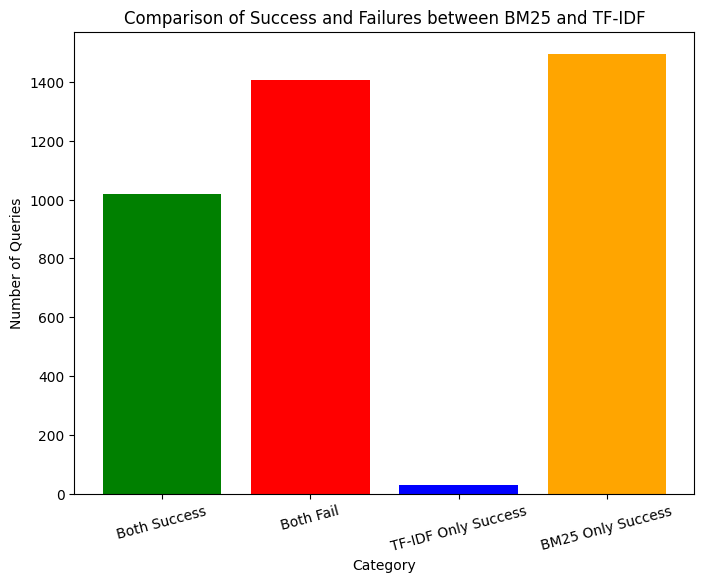

In [36]:
both_success = len(df[(df['bm25_success'] == 'Success') & (df['tfidf_success'] == 'Success')])
both_fail = len(df[(df['bm25_success'] == 'Fail') & (df['tfidf_success'] == 'Fail')])
tfidf_only_success = len(df[(df['bm25_success'] == 'Fail') & (df['tfidf_success'] == 'Success')])
bm25_only_success = len(df[(df['bm25_success'] == 'Success') & (df['tfidf_success'] == 'Fail')])

comparison_data = {
    'Both Success': both_success,
    'Both Fail': both_fail,
    'TF-IDF Only Success': tfidf_only_success,
    'BM25 Only Success': bm25_only_success
}

plt.figure(figsize=(8, 6))
plt.bar(comparison_data.keys(), comparison_data.values(), color=['green', 'red', 'blue', 'orange'])
plt.title('Comparison of Success and Failures between BM25 and TF-IDF')
plt.xlabel('Category')
plt.ylabel('Number of Queries')
plt.xticks(rotation=15)
plt.show()

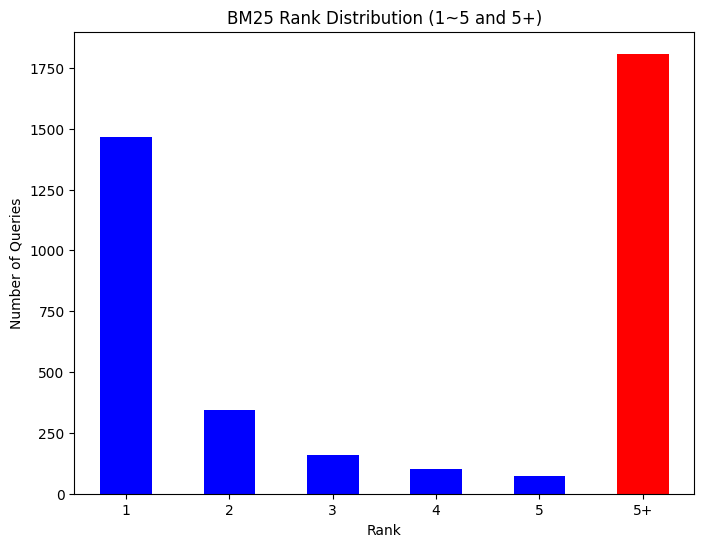

In [37]:
df_bm25_modified = df['bm25'].apply(lambda x: x if x in ['1', '2', '3', '4', '5'] else '5+')

bm25_counts = df_bm25_modified.value_counts().sort_index()

colors = ['blue' if rank in ['1', '2', '3', '4', '5'] else 'red' for rank in bm25_counts.index]
plt.figure(figsize=(8, 6))
bm25_counts.plot(kind='bar', color=colors)
plt.title('BM25 Rank Distribution (1~5 and 5+)')
plt.xlabel('Rank')
plt.ylabel('Number of Queries')
plt.xticks(rotation=0)
plt.show()